In [1]:
!pip install matplotlib | echo $?
!pip install pandas | wc -l
!pip install numpy | wc -l
!pip install tensorflow | wc -l
!pip install opencv-python | wc -l
!pip install matplotlib | wc -l 

11
5
1
43
2
11


In [22]:
CLASS_LIST_14 = ["Tee","Tank","Dress","Shorts","Skirt","Jumpsuit","Sweater","Blazer","Striped","Cardigan","Blouse","Romper","Sweatpants","Jacket"]
CLASS_LIST_21 = ["Tee","Tank","Dress","Shorts","Skirt","Hoodie","Jumpsuit","Sweater","Blazer","Striped","Cardigan","Blouse","Jacket","Jeans","Maxi","Floral","Denim","Sweatshorts","Polka","Shawl","Bodycon"]

CLASS_LIST = CLASS_LIST_21
for idx, val in enumerate(CLASS_LIST):
    print("%i/%s" % (idx, val))

0/Tee
1/Tank
2/Dress
3/Shorts
4/Skirt
5/Hoodie
6/Jumpsuit
7/Sweater
8/Blazer
9/Striped
10/Cardigan
11/Blouse
12/Jacket
13/Jeans
14/Maxi
15/Floral
16/Denim
17/Sweatshorts
18/Polka
19/Shawl
20/Bodycon


In [23]:
import tensorflow as tf
import keras.backend as tfb
import numpy as np

POS_WEIGHT = 2  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tfb.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [24]:
import tensorflow.keras as keras
import os
import tensorflow as tf
import numpy as np
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
from keras.models import load_model
model = load_model('C:\\Users\\mdc20\\best_model_21_class_lr@0.002-1666761586.9275644.hdf5', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})

In [25]:
BATCH_SIZE = 8
IMG_SHAPE = (224,224)
RECOMMENDATION_DIR = 'E:\\img_highres'

In [91]:
import os
input_dir = "E:\\img_test_input"

files = [input_dir + "\\unlabeled\\" + f for f in os.listdir(input_dir + "\\unlabeled")]
print(files)

['E:\\img_test_input\\unlabeled\\test (1).jpg', 'E:\\img_test_input\\unlabeled\\test (10).jpg', 'E:\\img_test_input\\unlabeled\\test (11).jpg', 'E:\\img_test_input\\unlabeled\\test (12).jpg', 'E:\\img_test_input\\unlabeled\\test (13).jpg', 'E:\\img_test_input\\unlabeled\\test (14).jpg', 'E:\\img_test_input\\unlabeled\\test (15).jpg', 'E:\\img_test_input\\unlabeled\\test (16).jpg', 'E:\\img_test_input\\unlabeled\\test (17).jpg', 'E:\\img_test_input\\unlabeled\\test (18).jpg', 'E:\\img_test_input\\unlabeled\\test (19).jpg', 'E:\\img_test_input\\unlabeled\\test (2).jpg', 'E:\\img_test_input\\unlabeled\\test (20).jpg', 'E:\\img_test_input\\unlabeled\\test (21).jpg', 'E:\\img_test_input\\unlabeled\\test (22).jpg', 'E:\\img_test_input\\unlabeled\\test (23).jpg', 'E:\\img_test_input\\unlabeled\\test (24).jpg', 'E:\\img_test_input\\unlabeled\\test (25).jpg', 'E:\\img_test_input\\unlabeled\\test (26).jpg', 'E:\\img_test_input\\unlabeled\\test (27).jpg', 'E:\\img_test_input\\unlabeled\\test (3).

In [92]:
from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator


imgdatagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    horizontal_flip = True, 
    validation_split = 0.1,
    rescale = 1.0/255, 
)

val_dataset = imgdatagen.flow_from_directory(
    directory = input_dir,
    target_size = IMG_SHAPE,
    class_mode = 'categorical',
    subset = None,
    shuffle = False,

    batch_size = BATCH_SIZE
)


Found 27 images belonging to 1 classes.


In [93]:
X_train, y_train = next(val_dataset)
print(np.shape(X_train))

(8, 224, 224, 3)


In [94]:
y_pred = model.predict(val_dataset)


4/4 [==============================] - 2s 403ms/step


In [95]:
y_pred_bin = np.where(y_pred > 0.3,1,0)
# y_pred_classes = [idx for idx, val in enumerate(row) for row in y_pred_bin]

In [98]:
import cv2
import matplotlib.pyplot as plt
def displayPredictions(y_pred_bin, files, class_list=CLASS_LIST):
    y_pred_classes = [[CLASS_LIST[i] for i, x in enumerate(row) if x == 1] for row in y_pred_bin]
    
    fig = plt.figure(figsize=(12,12))
    rows = 8
    columns = 4

    plt_index = 1
    for file, predicted_classes in zip(files, y_pred_classes):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, plt_index)
        fig.tight_layout()
        plt_index+=1
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(predicted_classes))
    return y_pred_classes
    

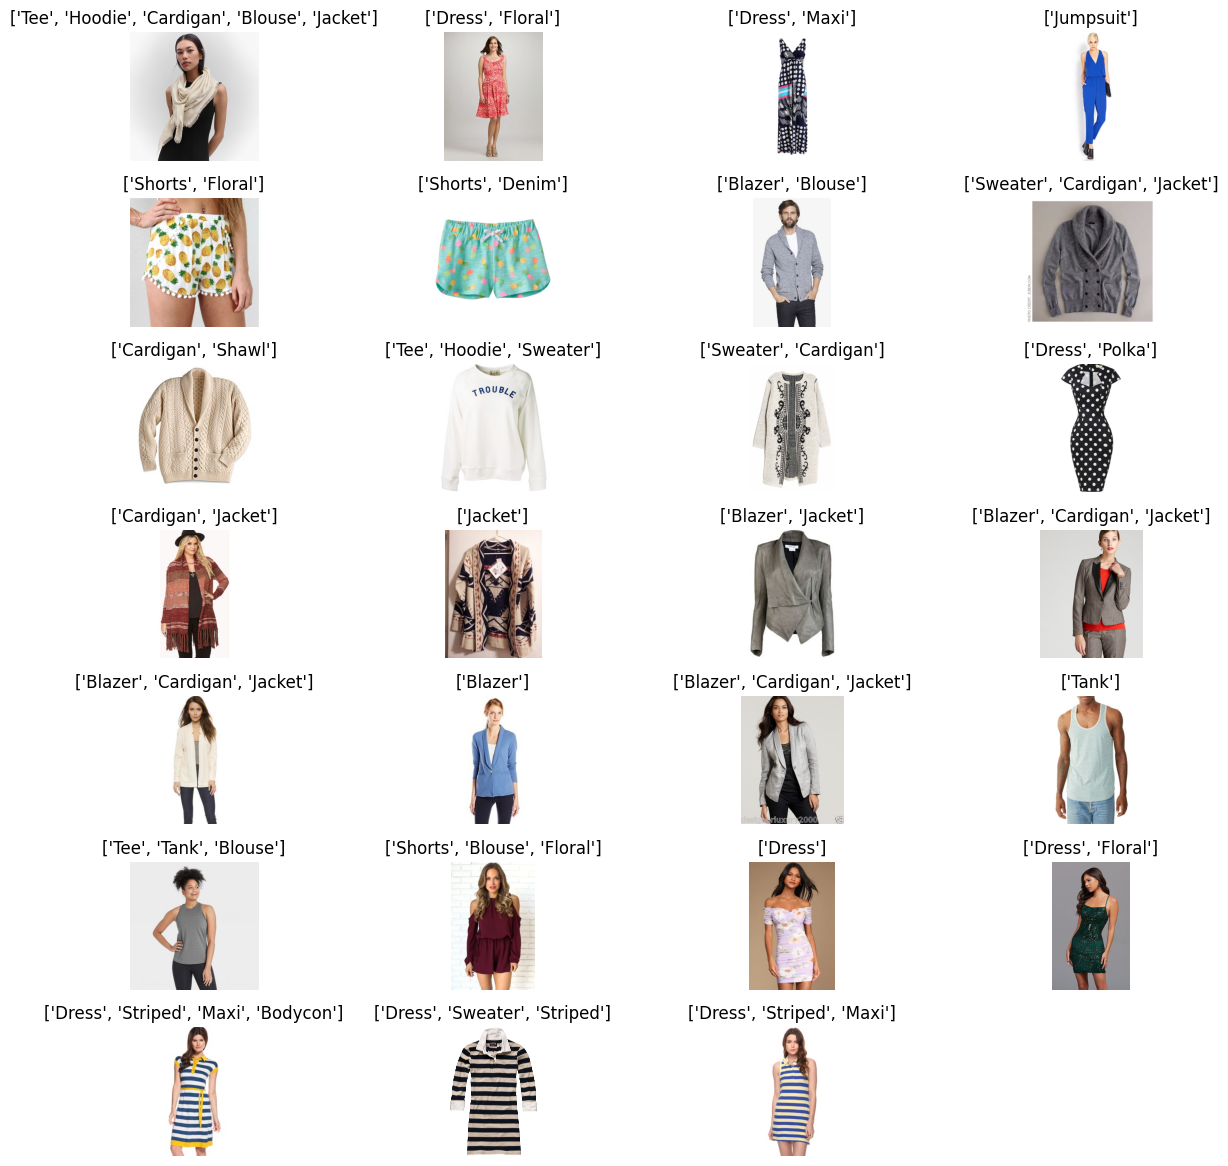

In [99]:
y_pred_classes = displayPredictions(y_pred_bin,files)
y_pred_classes_flatten = [j for sub in y_pred_classes for j in sub]

In [14]:
import os
import pandas as pd
from collections import Counter
def getRecommendations(class_count_dir: Counter):
    def getClassCountScore(dir: str, class_count_dir: dict):
        score = 0
        for cls in CLASS_LIST:
            if cls in dir and cls in class_count_dir.keys():
                score += class_count_dir[cls]
        return score
    arr = [[RECOMMENDATION_DIR + "\\" + dir + "\\",getClassCountScore(dir, class_count_dir)] for dir in os.listdir(RECOMMENDATION_DIR)]
    df = pd.DataFrame(data=arr,columns=['folderpath','score']).sort_values('score',ascending=False).head(24)
    return df


In [15]:
import os
def displayRecommendations(recs_df):
    fig = plt.figure(figsize=(24,14))
    rows = 4
    columns = 6

    plt_index = 1

    recs_arr = recs_df['folderpath'].to_numpy()
    score_arr = recs_df['score'].to_numpy()
    for rec_folder_path, score in zip(recs_arr,score_arr):
        filepath = rec_folder_path + "img_00000001.jpg"
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, plt_index)
        fig.tight_layout()
        plt_index+=1
        plt.imshow(img)
        plt.axis('off')
        plt.title("Similarity Score:"  + str(score))    

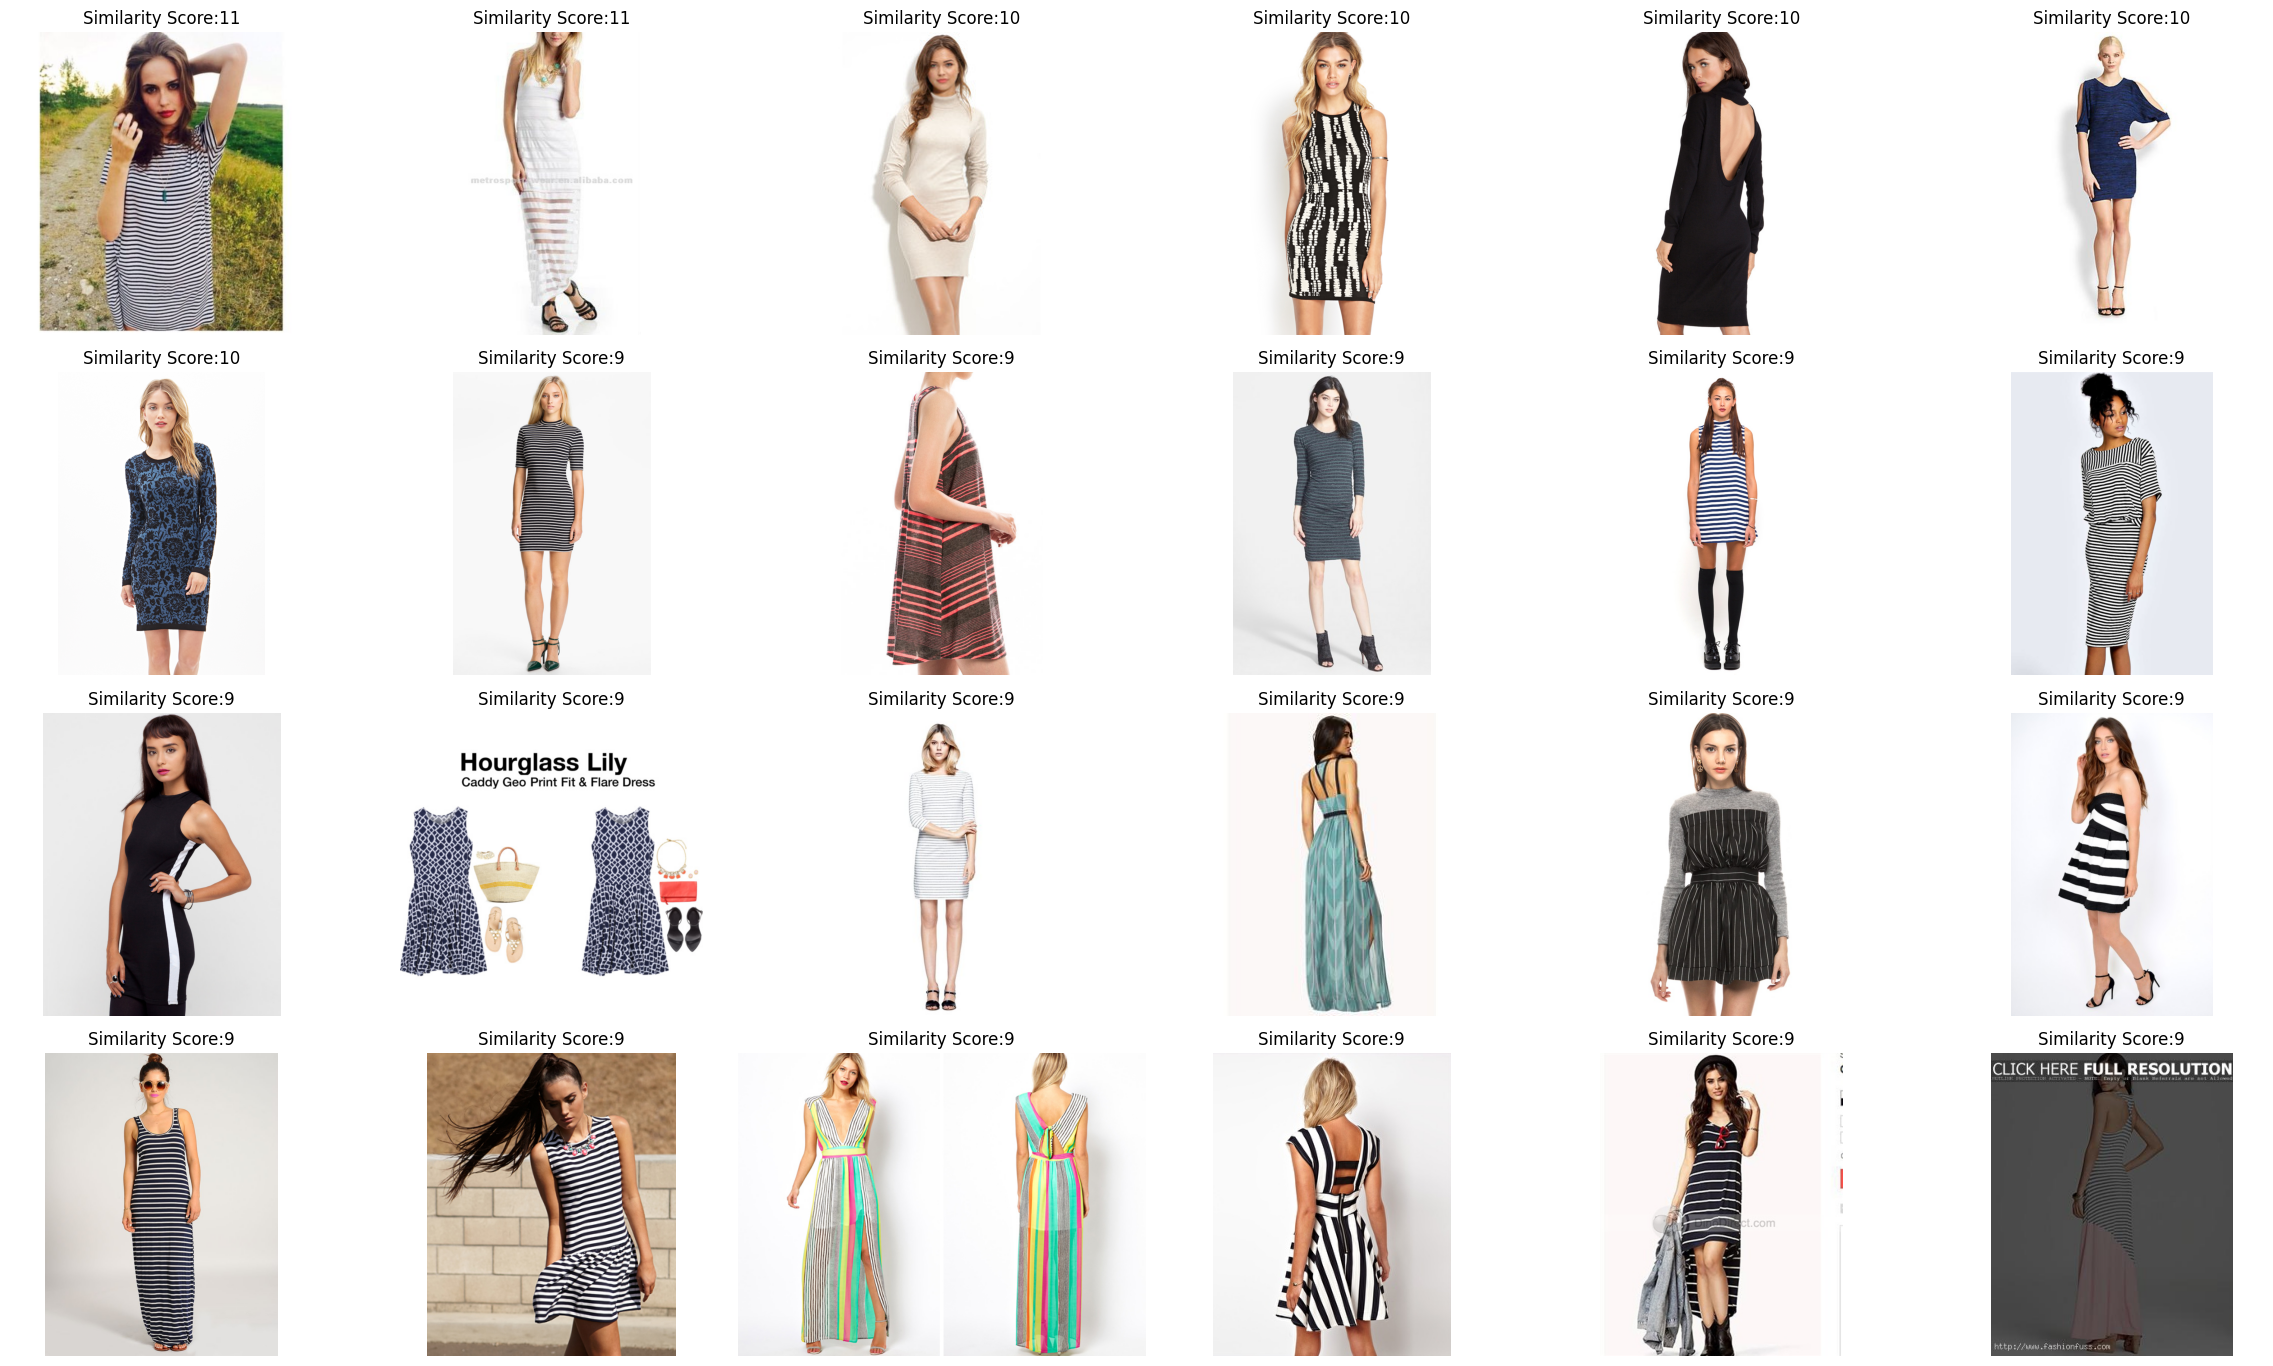

In [16]:

c = Counter(y_pred_classes_flatten)
recs = getRecommendations(c)
displayRecommendations(recs)